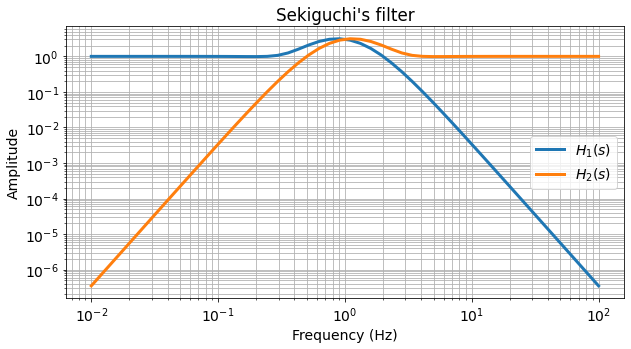

In [27]:
import numpy as np
import control
import matplotlib.pyplot as plt


s = control.tf("s")
H_1_sekiguchi = lambda omega: (35*omega**4*s**3 + 21*omega**5*s**2 + 7*omega**6*s**1 + omega**7)/(s+omega)**7

f_b = 1  # Blend at 1 Hz
H_1 = H_1_sekiguchi(2*np.pi*f_b)
H_2 = 1-H_1

f = np.logspace(-2, 2)

plt.rcParams["font.size"] = 14
plt.figure(figsize=(10, 5))
plt.title("Sekiguchi's filter")
plt.loglog(f, abs(H_1(2*np.pi*f*1j)), label="$H_1(s)$", lw=3)
plt.loglog(f, abs(H_2(2*np.pi*f*1j)), label="$H_2(s)$", lw=3)
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")
plt.savefig("../figures/sekiguchi_complementary_filter.png")
plt.show()


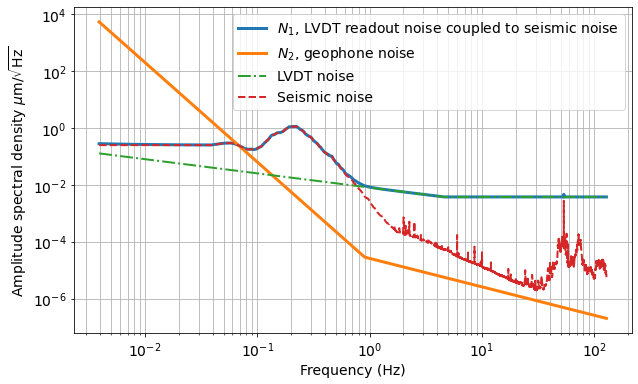

In [44]:
import kontrol.frequency_series.noise_models as noise
import kontrol.core.math


seismic_noise_90_x_data = np.loadtxt("data/X_90_DISP.txt")

f_x, seismic_noise = seismic_noise_90_x_data[:, 0], seismic_noise_90_x_data[:, 1]
for i in range(len(f_x)):
    if f_x[i] < 0.04 and seismic_noise[i]*1e6 > 0.25e-1:
        seismic_noise[i] = 0.25e-6

n1 = kontrol.core.math.quad_sum(noise.lvdt_noise(f_x), seismic_noise*1e6)
n2 = noise.geophone_noise(f_x, n0=2e-5)

plt.rcParams["font.size"] = 14
plt.figure(figsize=(10, 6))

plt.loglog(f_x, n1, label="$N_1$, LVDT readout noise coupled to seismic noise", lw=3)
plt.loglog(f_x, n2, label="$N_2$, geophone noise", lw=3)
plt.loglog(f_x, noise.lvdt_noise(f_x), '-.', label="LVDT noise", lw=2)
plt.loglog(f_x, seismic_noise*1e6, '--', label="Seismic noise", lw=2)
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density $\mu \mathrm{m}/\sqrt{\mathrm{Hz}}$")
plt.xlabel("Frequency (Hz)")
plt.savefig("../figures/sensor_noises_for_complementary_filter.png")

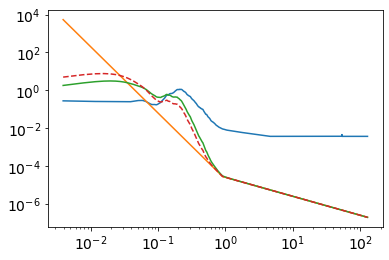

In [89]:
H1 = H_1_sekiguchi(2*np.pi*0.07)
H2 = 1-H1
n1_filtered = abs(H1(2*np.pi*f_x*1j)) * n1
n2_filtered = abs(H2(2*np.pi*f_x*1j)) * n2

n_super = kontrol.core.math.quad_sum(n1_filtered, n2_filtered)
plt.loglog(f_x, n1)
plt.loglog(f_x, n2)
plt.loglog(f_x, n_super)
fb = res.x[0]
h1 = H_1_sekiguchi(2*np.pi*fb)
h2 = 1-h1
n1_filtered = abs(h1(2*np.pi*f_x*1j)) * n1
n2_filtered = abs(h2(2*np.pi*f_x*1j)) * n2
n_super = kontrol.core.math.quad_sum(n1_filtered, n2_filtered)
plt.loglog(f_x, n_super, "--")
# plt.loglog(f_x, abs(H2(2*np.pi*f_x*1j)))

In [63]:
min_n1n2 = [min(n1[i], n2[i]) for i in range(len(n1))]
# np.min(n1, n2)

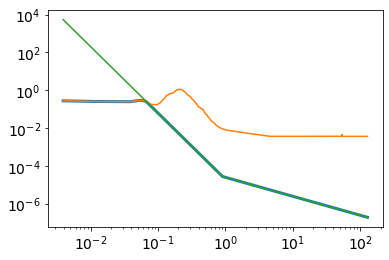

In [69]:
plt.loglog(f_x, min_n1n2, lw=3)
plt.loglog(f_x, n1)
plt.loglog(f_x, n2)

In [87]:
import scipy.optimize

def cost(args):
    fb = args[0]
    h1 = H_1_sekiguchi(2*np.pi*fb)
    h2 = 1-h1
    n1_filtered = abs(h1(2*np.pi*f_x*1j)) * n1
    n2_filtered = abs(h2(2*np.pi*f_x*1j)) * n2
    n_super = kontrol.core.math.quad_sum(n1_filtered, n2_filtered)
    return max((n_super/min_n1n2))

res = scipy.optimize.differential_evolution(cost, bounds=((min(f_x), max(f_x)),), workers=-1)

In [88]:
res

     fun: 29.830802509710203
     jac: array([50.95628203])
 message: 'Optimization terminated successfully.'
    nfev: 483
     nit: 26
 success: True
       x: array([0.05412172])